<a href="https://colab.research.google.com/github/DanieleAngioni97/AI_Project/blob/main/notebook/Adversarial_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install the SecML library**

In [ ]:
!pip3 install secml

# **Imports, constants and utility functions**

In [7]:
# basics
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

# PyTorch
import torch 
import torchvision
import torchvision.transforms as transforms


# SecML
from secml.core import CCreator
from secml.array import CArray
from secml.data.loader.c_dataloader_cifar import CDataLoaderCIFAR10
from secml.figure import CFigure
from secml.ml.features.normalization.c_normalizer_dnn import CNormalizerDNN

from secml.adv.attacks import CAttackEvasionPGDLS
from secml.adv.seceval import CSecEval

# todo: SPOSTARE LE DEF DEI MODELLI QUI SOPRA

# FOLDERS
CIFAR10_DATASET_PATH = '/content/drive/MyDrive/Colab_Notebooks/iCubeProject/saved_objects/datasets/CIFAR10_dataset'
MODELS_PATH = '/content/drive/MyDrive/Colab_Notebooks/iCubeProject/models/'
ATTACKS_PATH = '/content/drive/MyDrive/Colab_Notebooks/iCubeProject/saved_objects/attacks/'
SECEVALS_PATH = '/content/drive/MyDrive/Colab_Notebooks/iCubeProject/saved_objects/sec_evals/'

# MODELS
CIFAR_AUTOENCODER_SECML = 'CifarAutoencoder_secml.gz'
CIFAR_AUTOENCODER_TORCH = 'CifarPreTr.pkl'

CIFAR_CLF_SECML = "CIFAR10_model_secml.gz"
CIFAR_CLF_FINETUNED_SECML = "CIFAR10_model_finetuned_secml.gz"

CIFAR_CLF_TORCH = "CIFAR10_model_torch.gz"

# SECEVAL DATA
SECEVAL_DATA_CLF = 'secevaldata_clf.gz'
SECEVAL_DATA_CLF_AE = 'secevaldata_clf_ae.gz'
SECEVAL_DATA_CLF_AE_FTUNED = 'secevaldata_clf_ae_ftuned.gz'

SECEVAL_DATA_CLF_100 = 'secevaldata_clf_100samples.gz'
SECEVAL_DATA_CLF_AE_100 = 'secevaldata_clf_ae_100samples.gz'
SECEVAL_DATA_CLF_AE_FTUNED_100 = 'secevaldata_clf_ae_ftuned_100samples.gz'


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(random_seed=0):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    torch.cuda.manual_seed(random_seed)

def imshow(img):
    img = (img)# / 2 + 0.5)    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def stack_models(root=MODELS_PATH, 
                 ae_fname=CIFAR_AUTOENCODER_SECML, 
                 clf_fname=CIFAR_CLF_FINETUNED_SECML):
    if ae_fname is not None:
        ae_preprocess = CCreator().load(path=root + ae_fname)
        ae_preprocess = CNormalizerDNN(ae_preprocess)
    cifar_clf_stacked = CCreator().load(path=root + clf_fname)

    if ae_fname is not None:
        cifar_clf_stacked.preprocess.preprocess = ae_preprocess

    return cifar_clf_stacked

random_state = 49
set_seed(random_state)

# **Load the pretrained ConvNet**

## Classifier definition

In [4]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict


class CIFAR(nn.Module):
    def __init__(self, features, n_channel, num_classes):
        super(CIFAR, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(n_channel, num_classes)
        )
        # print(self.features)
        # print(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# def make_layers(cfg, batch_norm=False):
#     layers = []
#     in_channels = 3
#     for i, v in enumerate(cfg):
#         if v == 'M':
#             layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#         else:
#             padding = v[1] if isinstance(v, tuple) else 1
#             out_channels = v[0] if isinstance(v, tuple) else v
#             conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
#             if batch_norm:
#                 layers += [conv2d, nn.BatchNorm2d(out_channels, affine=False), nn.ReLU()]
#             else:
#                 layers += [conv2d, nn.ReLU()]
#             in_channels = out_channels
#     return nn.Sequential(*layers)

# def cifar10(n_channel=128, pretrained=None):
#     cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel,
#            'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
#     layers = make_layers(cfg, batch_norm=True)
#     model = CIFAR(layers, n_channel=8*n_channel, num_classes=10)
#     if pretrained is not None:
#         m = model_zoo.load_url(
#             'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar10-d875770b.pth')
#         state_dict = m.state_dict() if isinstance(m, nn.Module) else m
#         assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
#         model.load_state_dict(state_dict)
#     return model


In [ ]:
deep_net = torch.load(MODELS_PATH + CIFAR_CLF_TORCH).to(device)

correct = 0
total = 0

batch_size = 128

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(
    root=CIFAR10_DATASET_PATH, 
    train=False,
    download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# evaluate torch model
deep_net.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = deep_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(
    100 * correct / total))

torch.Size([16, 3, 32, 32])

In [ ]:
from secml.ml.features.normalization import CNormalizerMeanStd

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_net.parameters(), lr=0.001)

transform = CNormalizerMeanStd(mean=(0.5,0.5,0.5), 
                              std=(0.5,0.5,0.5), 
                              with_std=True)


# wrap in secml the torch model
from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model=deep_net,
                         loss=criterion,
                         optimizer=optimizer,
                         preprocess = transform,
                         pretrained=True,
                         epochs=100,
                         batch_size=64,
                         input_shape=(3, 32, 32),
                         random_state=0)

# label_torch = clf.predict(ts.X, return_decision_function=False)

# # evaluate the wrapped model
# from secml.ml.peval.metrics import CMetric
# metric = CMetric.create('accuracy')
# acc_torch = metric.performance_score(ts.Y, label_torch)

# print("Model Accuracy: {}%".format(acc_torch*100))

clf.save(path=MODELS_PATH + CIFAR_CLF_SECML)

'/content/drive/MyDrive/Colab_Notebooks/iCubeProject/models/CIFAR10_model_secml.gz'

In [12]:
# load and reavaluate only using secml
loader = CDataLoaderCIFAR10()
tr , ts = loader.load()

# Normalize the data
tr.X /= 255
ts.X /= 255

cifar_clf = CCreator().load(path=MODELS_PATH + CIFAR_CLF_SECML)

y_pred = cifar_clf.predict(ts.X, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')
acc = metric.performance_score(ts.Y, y_pred)

print("Model Accuracy: {}%".format(acc*100))


File stored in `/root/secml-data/datasets/cifar/cifar-10-python.tar.gz`


# **Load the pretrained autoencoder**

## Autoencoder definition

In [5]:
class CifarAutoencoder(nn.Module):
    def __init__(self):
        super(CifarAutoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
n_images = 16

# print("Loading checkpoint...")
autoencoder = CifarAutoencoder().to(device)
autoencoder.load_state_dict(torch.load(MODELS_PATH + CIFAR_AUTOENCODER_TORCH))

autoencoder.eval()
autoencoder_loss = nn.MSELoss()

testset = torchvision.datasets.CIFAR10(root=CIFAR10_DATASET_PATH, train=False,
                                        download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=n_images,
                                            shuffle=False, num_workers=2)

dataiter = iter(testloader)
images, _ = dataiter.next()

plt.figure(figsize=(20,10))
plt.title('Input images', fontsize=20)
imshow(torchvision.utils.make_grid(images))

images = images.to(device)
running_loss = 0.
total_batch = 0
correct = 0.
total = 0
for i, (inputs, labels) in enumerate(testloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # ============ Forward ============
    outputs = autoencoder(inputs)
    loss = autoencoder_loss(outputs, inputs)

    running_loss += loss.data
    total_batch += 1

running_loss /= total_batch

decoded_imgs = autoencoder(images)
plt.figure(figsize=(20,10))
plt.title('Reconstructed images\n Reconstruction loss: {:.4f}'.format(running_loss),
          fontsize=20)
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

In [ ]:
from torch.optim import Adam
from torch.nn import BCELoss
from secml.array import CArray

# wrap the model, including the normalizer
ae_loss = BCELoss()
ae_optimizer = Adam(autoencoder.parameters(), lr=1e-3)
normalizer = None

input_shape = (3, 32, 32)

wrapped_autoencoder = CClassifierPyTorch(model=autoencoder,
                                         loss=ae_loss,
                                         optimizer=ae_optimizer,
                                         epochs=10,
                                         batch_size=32,
                                         input_shape=input_shape,
                                         softmax_outputs=False,
                                         preprocess=normalizer,
                                         random_state=random_state,
                                         pretrained=True,
                                         pretrained_classes=CArray.arange(3*32*32))
print("Saving...")
wrapped_autoencoder.save(path=MODELS_PATH + CIFAR_AUTOENCODER_SECML)
print("Saved.")

Saving...
Saved.


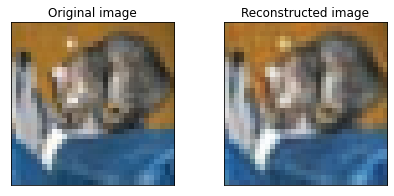

In [13]:
from secml.figure import CFigure

i = 0

autoencoder = CCreator().load(path=MODELS_PATH + CIFAR_AUTOENCODER_SECML)
input_shape = (3, 32, 32)

dataset = ts

if i > dataset.num_samples:
    i = dataset.num_samples - 1

# da plottare come in make_grid

fig = CFigure(width=7, height=3)

original = dataset.X[i, :].tondarray().reshape(input_shape).transpose((1, 2, 0))

fig.subplot(1, 2, 1)
fig.sp.imshow(original)
fig.sp.title("Original image")
fig.sp.xticks([])
fig.sp.yticks([])

reconstructed = autoencoder.forward(dataset.X[i, :]).tondarray().reshape(input_shape).transpose((1, 2, 0))

fig.subplot(1, 2, 2)
fig.sp.imshow(reconstructed/reconstructed.max())
fig.sp.title("Reconstructed image")
fig.sp.xticks([])
fig.sp.yticks([])
fig.show()

# **Finetune the classifier with the autoencoder as preprocess**

In [ ]:
import torch.nn as nn

batch_size = 64
n_epochs = 10

trainset = torchvision.datasets.CIFAR10(root=CIFAR10_DATASET_PATH, train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
n_iterations = len(trainloader)


# Instantiate models
autoencoder = CifarAutoencoder().to(device)
autoencoder.load_state_dict(torch.load(MODELS_PATH + CIFAR_AUTOENCODER_TORCH))

normalizer_deep_net = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

deep_net = torch.load(MODELS_PATH + CIFAR_CLF_TORCH).to(device)

# Freeze autoencoder and feature extractor of the classifier
for param in autoencoder.parameters():
    param.requires_grad = False

for param in deep_net.features.parameters():
    param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_net.parameters(), lr=0.01)


for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        decoded = autoencoder(images)
        decoded_norm = normalizer_deep_net(decoded)
        # decoded_norm = normalizer_deep_net(images)
        output = deep_net(decoded_norm)
        loss = criterion(output, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if i%50 == 0:
            print("Epoch [{}/{}], Step [{},{}], loss: {}".format(
                epoch, n_epochs, i, n_iterations, loss.item()
            ))


Files already downloaded and verified
Epoch [0/10], Step [0,157], loss: 0.38481569290161133
Epoch [0/10], Step [50,157], loss: 1.3587888479232788
Epoch [0/10], Step [100,157], loss: 1.3112926483154297
Epoch [0/10], Step [150,157], loss: 1.2077076435089111
Epoch [1/10], Step [0,157], loss: 0.7847427129745483
Epoch [1/10], Step [50,157], loss: 0.5565869212150574
Epoch [1/10], Step [100,157], loss: 0.729152262210846
Epoch [1/10], Step [150,157], loss: 0.8519527316093445
Epoch [2/10], Step [0,157], loss: 0.5123779773712158
Epoch [2/10], Step [50,157], loss: 1.0496647357940674
Epoch [2/10], Step [100,157], loss: 0.4677780568599701
Epoch [2/10], Step [150,157], loss: 0.5168585181236267
Epoch [3/10], Step [0,157], loss: 1.0039013624191284
Epoch [3/10], Step [50,157], loss: 0.5314211249351501
Epoch [3/10], Step [100,157], loss: 0.8785353899002075
Epoch [3/10], Step [150,157], loss: 0.2612050175666809
Epoch [4/10], Step [0,157], loss: 0.297313392162323
Epoch [4/10], Step [50,157], loss: 0.32012

In [ ]:
# evaluate the finetuned model before saving it

correct = 0
total = 0
batch_size = 128

testset = torchvision.datasets.CIFAR10(
    root=CIFAR10_DATASET_PATH, 
    train=False,
    download=True, transform=transforms.ToTensor())

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# evaluate torch model
deep_net.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        decoded = autoencoder(images)
        decoded_norm = normalizer_deep_net(decoded)
        # decoded_norm = normalizer_deep_net(images)
        outputs = deep_net(decoded_norm)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(
    100 * correct / total))

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 93.41 %


In [ ]:
from secml.ml.classifiers import CClassifierPyTorch

transform = CNormalizerMeanStd(mean=(0.5,0.5,0.5), 
                              std=(0.5,0.5,0.5), 
                              with_std=True)


# wrap in secml the torch model
from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model=deep_net,
                         loss=criterion,
                         optimizer=optimizer,
                         preprocess = transform,
                         pretrained=True,
                         epochs=100,
                         batch_size=64,
                         input_shape=(3, 32, 32),
                         random_state=0)

clf_secml_path = MODELS_PATH + CIFAR_CLF_FINETUNED_SECML
clf.save(path=clf_secml_path)

'/content/drive/MyDrive/Colab_Notebooks/iCubeProject/models/CIFAR10_model_finetuned_secml.gz'

In [ ]:
# load and reavaluate only using secml
loader = CDataLoaderCIFAR10()
tr , ts = loader.load()

# Normalize the data
tr.X /= 255
ts.X /= 255

cifar_clf_stacked = stack_models(root=MODELS_PATH,
                                 ae_fname=CIFAR_AUTOENCODER_SECML,
                                 clf_fname=CIFAR_CLF_FINETUNED_SECML)

y_pred = cifar_clf_stacked.predict(ts.X, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')
acc = metric.performance_score(ts.Y, y_pred)

print("Model Accuracy: {:.2f}%".format(acc*100))

# clf alone reach 93.78%
# with the autoencoder before the net it goes down to 87.93%
# after finetuning 93.41%

Model Accuracy: 93.41%


# **Evasion Attack**

## **Instantiate the attack**

In [ ]:
n_images = 100
# For simplicity, let's attack a subset of the test set

loader = CDataLoaderCIFAR10()
tr , ts = loader.load()

# Normalize the data
tr.X /= 255
ts.X /= 255

attacked_ds = ts[:n_images, :]
#da aummentare

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 1.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5, #learning rate
    'eta_min': 2.0, #starting lr
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

model_under_attack = stack_models(root=MODELS_PATH,
                   ae_fname=None,
                   clf_fname=CIFAR_CLF_SECML)

pgd_ls_attack = CAttackEvasionPGDLS(classifier=model_under_attack,
                                    double_init=False,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)
pgd_ls_attack.verbose = 1

## **Run the attack**

In [ ]:
print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(attacked_ds.X, attacked_ds.Y)
print("Attack complete!")

Attack started...
2021-04-14 09:15:44,059 - CAttackEvasionPGDLS.0x7f27065b51d0 - INFO - Point: 0/10, f(x):-80.44142150878906
2021-04-14 09:15:44,172 - CAttackEvasionPGDLS.0x7f27065b51d0 - INFO - Point: 1/10, f(x):-39.158987045288086
2021-04-14 09:15:44,316 - CAttackEvasionPGDLS.0x7f27065b51d0 - INFO - Point: 2/10, f(x):-69.42923736572266
2021-04-14 09:15:44,968 - CAttackEvasionPGDLS.0x7f27065b51d0 - INFO - Point: 3/10, f(x):-81.09283828735352
2021-04-14 09:15:45,349 - CAttackEvasionPGDLS.0x7f27065b51d0 - INFO - Point: 4/10, f(x):-73.94002151489258
2021-04-14 09:15:45,655 - CAttackEvasionPGDLS.0x7f27065b51d0 - INFO - Point: 5/10, f(x):-129.5406723022461
2021-04-14 09:15:45,763 - CAttackEvasionPGDLS.0x7f27065b51d0 - INFO - Point: 6/10, f(x):-49.76605796813965
2021-04-14 09:15:45,903 - CAttackEvasionPGDLS.0x7f27065b51d0 - INFO - Point: 7/10, f(x):-58.95441818237305
2021-04-14 09:15:46,593 - CAttackEvasionPGDLS.0x7f27065b51d0 - INFO - Point: 8/10, f(x):-126.65853881835938
2021-04-14 09:15:

## **Evaluate accuracy before and after the attack on the subset of test set**

In [ ]:
# Instantiate the defended model
clf = stack_models(root=MODELS_PATH,
                        ae_fname=None,
                        clf_fname=CIFAR_CLF_SECML)

clf_ae = stack_models(root=MODELS_PATH,
                            ae_fname=CIFAR_AUTOENCODER_SECML,
                            clf_fname=CIFAR_CLF_FINETUNED_SECML)

acc = metric.performance_score(
    y_true=attacked_ds.Y, y_pred=clf.predict(attacked_ds.X))

acc_attack = metric.performance_score(
    y_true=attacked_ds.Y, y_pred=eva_y_pred)

acc_attack_clean = metric.performance_score(
    y_true=attacked_ds.Y, y_pred=clf_ae.predict(eva_adv_ds.X))

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))
print("Accuracy on reduced test set after attack and cleaning the images: {:.2%}".format(acc_attack_clean))

Accuracy on reduced test set before attack: 100.00%
Accuracy on reduced test set after attack: 0.00%
Accuracy on reduced test set after attack and cleaning the images: 0.00%


## **Visualize the attacked and the reconstructed images**

In [ ]:
from secml.figure import CFigure
import math
%matplotlib inline

def plot_adv_attacks(attacked_ds, eva_adv_ds, eva_y_pred, autoencoder, k=0, differences = False):

    classes = ['airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

    n_cols = 3
    n_rows = 1
    width = 13
    height = 5

    eva_img = eva_adv_ds.X

    start_img_k = attacked_ds.X[k, :]  # original img
    eva_img_k = eva_img[k, :]  # perturbed img
    reconstr_start_img_k = autoencoder.forward(start_img_k)
    reconstr_eva_img_k = autoencoder.forward(eva_img_k)
    n_rows = 3
    width = 13
    height = 10

    def diff_normalized(a, b):
        diff = a - b
        diff -= diff.min()
        diff /= diff.max()
        return diff

    def resh_transp(x):
        n = attacked_ds.num_features / 3
        n = int(math.sqrt(n))
        return x.tondarray().reshape((3, n, n)).transpose((1, 2, 0))

    # normalize perturbation for visualization
    start_perturb = resh_transp(diff_normalized(start_img_k, eva_img_k))
    # normalize perturbation after reconstruction
    ae_perturb = resh_transp(diff_normalized(reconstr_start_img_k, reconstr_eva_img_k))
    # normalize reconstruction noise of original sample
    start_noise_k = resh_transp(diff_normalized(start_img_k, reconstr_start_img_k))
    # normalize reconstruction noise of adversarial example
    eva_noise_k = resh_transp(diff_normalized(eva_img_k, reconstr_eva_img_k))
    # normalize perturbation of reconstruction noise
    pert_noise_k = diff_normalized(start_noise_k, eva_noise_k)

    start_img_k = resh_transp(start_img_k)
    eva_img_k = resh_transp(eva_img_k)
    reconstr_start_img_k = resh_transp(reconstr_start_img_k)
    reconstr_eva_img_k = resh_transp(reconstr_eva_img_k)

    fig = CFigure(width=width, height=height)

    titles = ["Original image x\n true class : " + classes[eva_adv_ds.Y[k].item()],
            "Adversarial example x*\npredicted class : " + classes[eva_y_pred[k].item()],
            "Amplified perturbation x- x*",
            "Original image AE(x)\nin the reconstructed input space",
            "Adversarial example AE(x*)\nin the reconstructed input space",
            "Amplified perturbation AE(x) - AE(x*)\nin the reconstructed input space",
            "Reconstruction noise x - AE(x)\nof original image",
            "Reconstruction noise x* - AE(x*)\nof adversarial example",
            "(x - AE(x)) - (x* - AE(x*)) =\n(x- x*) - (AE(x) - AE(x*))"]

    imgs = [start_img_k,
            eva_img_k,
            start_perturb,
            reconstr_start_img_k,
            reconstr_eva_img_k,
            ae_perturb,
            start_noise_k,
            eva_noise_k,
            pert_noise_k]

    if differences:
        for i, (img, title) in enumerate(list(zip(imgs, titles))):
            fig.subplot(n_rows, n_cols, i + 1)
            fig.sp.imshow(img)
            fig.sp.title(title)
            fig.sp.xticks([])
            fig.sp.yticks([])
    else:  
        fig = CFigure(width=15, height=5)
        fig.subplot(1, 4, 1)
        fig.sp.imshow(start_img_k)
        fig.sp.title("Original image\n true class : " + classes[attack_ds.Y[k].item()])
        fig.sp.xticks([])
        fig.sp.yticks([])

        fig.subplot(1, 4, 2)
        fig.sp.imshow(diff_img_k)
        fig.sp.title("Amplified perturbation")
        fig.sp.xticks([])
        fig.sp.yticks([])

        fig.subplot(1, 4, 3)
        fig.sp.imshow(eva_img_k)
        fig.sp.title("Adversarial example\npredicted class : " + classes[eva_y_pred[k].item()])
        fig.sp.xticks([])
        fig.sp.yticks([])

        temp_k = autoencoder.forward(eva_img[k, :])
        y_pred = cifar_clf.predict(temp_k, return_decision_function=False)

        fig.subplot(1, 4, 4)
        fig.sp.imshow(reconstr_eva_img_k)
        fig.sp.title("Reconstructed image\npredicted class : " + classes[y_pred_clean[k].item()])
        fig.sp.xticks([])
        fig.sp.yticks([])

        fig.show()

In [ ]:
for k in range(10):
    plot_adv_attacks(attacked_ds, eva_adv_ds, eva_y_pred, autoencoder, k=k, differences = False)

# **Security Evaluation**

In [ ]:
def instantiate_attack(ae_fname, clf_fname):
    noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
    dmax = 1.0  # Maximum perturbation
    lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
    y_target = None  # None if `error-generic` or a class label for `error-specific`

    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.5, #learning rate
        'eta_min': 2.0, #starting lr
        'eta_max': None,
        'max_iter': 100,
        'eps': 1e-6
    }

    model_under_attack = stack_models(root=MODELS_PATH,
                                        ae_fname=ae_fname,
                                        clf_fname=clf_fname)

    pgd_ls_attack = CAttackEvasionPGDLS(classifier=model_under_attack,
                                        double_init=False,
                                        distance=noise_type,
                                        dmax=dmax,
                                        solver_params=solver_params,
                                        y_target=y_target)
    # pgd_ls_attack.verbose = 1

    return pgd_ls_attack

def instantiate_run_seceval(n_samples, seceval_fname, ae_fname=None, clf_fname=CIFAR_CLF_SECML):
    loader = CDataLoaderCIFAR10()
    _ , ts = loader.load()

    # Normalize the data
    ts.X /= 255

    seceval_ds = ts[:n_samples, :]

    e_vals = CArray.arange(start=0, step=0.1, stop=1.1)

    attack = instantiate_attack(ae_fname=ae_fname, 
                                clf_fname=clf_fname)

    sec_eval = CSecEval(
        attack=attack, param_name='dmax', param_values=e_vals, save_adv_ds=True)
    sec_eval.verbose = 1

    # Run the security evaluation using the test set
    print("Running security evaluation...")
    sec_eval.run_sec_eval(seceval_ds)
    print("Finish security evaluation...")

    sec_eval.sec_eval_data.save(SECEVALS_PATH + seceval_fname)

In [ ]:
# Perturbation levels to test
n_samples = 100

# SECEVAL_DATA_CLF = 'secevaldata_clf.gz'
# SECEVAL_DATA_CLF_AE = 'secevaldata_clf_ae.gz'
# SECEVAL_DATA_CLF_AE_FTUNED = 'secevaldata_clf_ae_ftuned.gz'

instantiate_run_seceval(n_samples, seceval_fname=SECEVAL_DATA_CLF_100)

instantiate_run_seceval(n_samples, seceval_fname=SECEVAL_DATA_CLF_AE_100, 
                        ae_fname=CIFAR_AUTOENCODER_SECML)

instantiate_run_seceval(n_samples, seceval_fname=SECEVAL_DATA_CLF_AE_FTUNED_100, 
                        ae_fname=CIFAR_AUTOENCODER_SECML, 
                        clf_fname=CIFAR_CLF_FINETUNED_SECML)

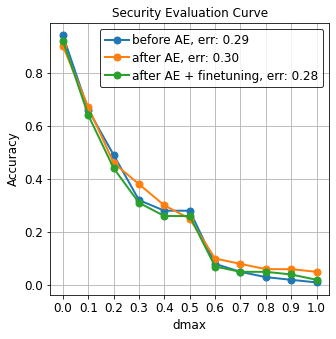

In [8]:
from secml.adv.seceval import CSecEvalData
%matplotlib inline

secevaldata_clf = CSecEvalData.load(SECEVALS_PATH + SECEVAL_DATA_CLF_100)
secevaldata_clf_ae = CSecEvalData.load(SECEVALS_PATH + SECEVAL_DATA_CLF_AE_100)
secevaldata_clf_ae_ftuned = CSecEvalData.load(SECEVALS_PATH + SECEVAL_DATA_CLF_AE_FTUNED_100)

fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(secevaldata_clf, marker='o', label='before AE', show_average=True)
fig.sp.plot_sec_eval(secevaldata_clf_ae, marker='o', label='after AE', show_average=True)
fig.sp.plot_sec_eval(secevaldata_clf_ae_ftuned, marker='o', label='after AE + finetuning', show_average=True)

fig.show()

In [46]:
# autoencoder = CCreator().load(path=root + CIFAR_AUTOENCODER_SECML)

# print(secevaldata_clf_ae_ftuned.__dict__.keys())

# print(len(secevaldata_clf_ae_ftuned.adv_ds))

from secml.ml.peval.metrics import CMetric
import math

# load and reavaluate only using secml
loader = CDataLoaderCIFAR10()
_ , ts = loader.load()

# Normalize the data
ts.X /= 255

autoencoder = CCreator().load(path=MODELS_PATH + CIFAR_AUTOENCODER_SECML)
distances_list = []

for inputs in secevaldata_clf_ae_ftuned.adv_ds:
    reconstructions = autoencoder.forward(inputs.X)

    metric = CMetric.create('mse')

    mse = metric.performance_score(inputs.X, score=reconstructions)
    distances_list.append(math.sqrt(mse))

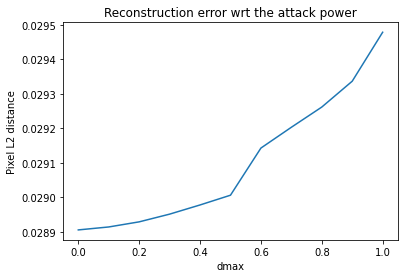

In [49]:

plt.plot(secevaldata_clf_ae_ftuned.param_values.tolist(), distances_list)
plt.title('Reconstruction error wrt the attack power')
plt.xlabel('dmax')
plt.ylabel('Pixel L2 distance')
plt.show()

In [45]:
import math

math.sqrt()

TypeError: ignored